In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import argparse
import torch
import torchvision
import torch.nn.functional as F
import numpy as np

from nn.enums import ExplainingMethod
from nn.networks import ExplainableNet
from nn.utils import get_expl, plot_overview, clamp, load_image, make_dir

no display found. Using non-interactive Agg backend


In [13]:
def get_beta(i, num_iter):
    """
    Helper method for beta growth
    """
    start_beta, end_beta = 10.0, 100.0
    return start_beta * (end_beta / start_beta) ** (i / num_iter)

def np_img_to_tensor(input_sample, num_ch):
    if num_ch == 1:
        rgb_img = np.repeat(grayscale_img[..., np.newaxis], 3, -1)
    else:
        rgb_img = input_sample
    im = Image.fromarray(rgb_img)
    x = torchvision.transforms.Normalize(mean=data_mean, std=data_std)(torchvision.transforms.ToTensor()(torchvision.transforms.Resize(224)(im)))
    x = x.unsqueeze(0).to(device)
    return x

In [3]:
args_cuda = True

# choices:['lrp', 'guided_backprop', 'gradient', 'integrated_grad','pattern_attribution', 'grad_times_input']
args_method = 'lrp'
args_beta_growth = None
args_img = '../data/collie4.jpeg'
args_target_img = '../data/tiger_cat.jpeg'
args_num_iter = 1500
args_prefactors = [1e11, 1e6]
args_lr = 0.0002
args_output_dir = '../output/'

In [4]:
# options
device = torch.device("cuda" if args_cuda else "cpu")
method = getattr(ExplainingMethod, args_method)
print('Explanation method {} will be used'.format(method))

# load model
# data_mean = np.array([0.485, 0.456, 0.406])
# data_std = np.array([0.229, 0.224, 0.225])

data_mean = np.array([0.0, 0.0, 0.0])
data_std = np.array([1.0,1.0, 1.0])

vgg_model = torchvision.models.vgg16(pretrained=True)
model = ExplainableNet(vgg_model, data_mean=data_mean, data_std=data_std, beta=1000 if args_beta_growth else None)
if method == ExplainingMethod.pattern_attribution:
    model.load_state_dict(torch.load('../models/model_vgg16_pattern_small.pth'), strict=False)
model = model.eval().to(device)

#print(vgg_model)

Explanation method ExplainingMethod.lrp will be used


In [ ]:
# load images
x = load_image(data_mean, data_std, device, args_img)
x_target = load_image(data_mean, data_std, device, args_target_img)
x_adv = x.clone().detach().requires_grad_()

In [ ]:
x.requires_grad = True
_, class_idx = model.classify(x)
print('class_idx of dog: ',class_idx)

_, target_class_idx = model.classify(x_target)
print('class_idx of cat: ', target_class_idx)

In [ ]:

org_expl, _, _ = get_expl(model, x, method, class_idx)
org_expl_as_target, _, _ = get_expl(model, x, method, target_class_idx)


target_expl, _, _ = get_expl(model, x_target, method, target_class_idx)
target_expl_as_orig, _, _ = get_expl(model, x_target, method, class_idx)

org_expl = org_expl.detach()
org_expl_as_target = org_expl_as_target.detach()
target_expl = target_expl.detach()
target_expl_as_orig = target_expl_as_orig.detach()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
org_expl_np = org_expl.cpu().numpy()
plt.imshow(org_expl_np[0])

In [ ]:
org_expl_as_target_np = org_expl_as_target.cpu().numpy()
plt.imshow(org_expl_as_target_np[0])

In [ ]:
target_expl_np = target_expl.cpu().numpy()
plt.imshow(target_expl_np[0])

In [ ]:
target_expl_as_orig_np = target_expl_as_orig.cpu().numpy()
plt.imshow(target_expl_as_orig_np[0])

In [ ]:
import keras
from keras import datasets 
from torchvision import datasets, transforms
from PIL import Image

(x_train, y_train) ,(x_test, y_test) = datasets.fashion_mnist.load_data()


x = np_img_to_tensor(x_train[0])
x_adv = x.clone().detach().requires_grad_()
print(x.shape)

IS_X_ADV = False
if IS_X_ADV:
    x.requires_grad = True
    _, class_idx = model.classify(x)
    desired_idx = (class_idx+10)%1000
    org_expl, org_acc, org_idx = get_expl(model, x, method,desired_idx)
else:
    org_expl, org_acc, org_idx = get_expl(model, x, method)
org_expl = org_expl.detach().cpu()

In [ ]:
xnp = org_expl.numpy()
xnp = xnp.reshape(224, 224)
im2 = Image.fromarray(xnp)
x_new = torchvision.transforms.ToTensor()(torchvision.transforms.Resize(28)(im2))
x_new_np = x_new.numpy()
x_new_np = x_new_np.reshape(28,28)


In [ ]:
import keras
from keras import datasets 
(x_train, y_train) ,(x_test, y_test) = datasets.fashion_mnist.load_data()
from torchvision import datasets, transforms
from PIL import Image

x = np_img_to_tensor(x_train[0])
x_adv = x.clone().detach().requires_grad_()
print(x.shape)
org_expl, org_acc, org_idx = get_expl(model, x, method)
org_expl = org_expl.detach().cpu()

# The class from which we will derive the target explanation
source_class_idx = 6
# pick index of x_train where the label is that of the source class
idx = np.where(y_train == source_class_idx)[0][0]
grayscale_img_src = x_train[idx]
x_target = np_img_to_tensor(grayscale_img_src)
target_expl, _, _ = get_expl(model, x_target, method)
target_expl = target_expl.detach()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(x_train[0])

In [ ]:
org_expl_np = org_expl.cpu().numpy()
plt.imshow(org_expl_np[0])

In [ ]:
plt.imshow(grayscale_img_src)

In [ ]:
target_expl_np = target_expl.cpu().numpy()
plt.imshow(target_expl_np[0])

# Exploration with Cifar

In [6]:
import keras
from keras import datasets 
(x_train, y_train) ,(x_test, y_test) = datasets.cifar10.load_data()

Using TensorFlow backend.
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [18]:
from torchvision import datasets, transforms
from PIL import Image

idx = 1
x = np_img_to_tensor(x_train[idx], num_ch=3)
x_adv = x.clone().detach().requires_grad_()
print(x.shape)

org_expl, org_acc, org_idx = get_expl(model, x, method)
org_expl = org_expl.detach().cpu()

torch.Size([1, 3, 224, 224])


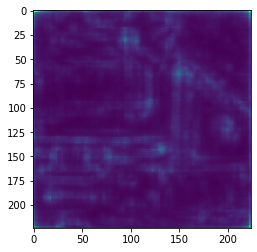

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
org_expl_np = org_expl.cpu().numpy()
plt.imshow(org_expl_np[0])

In [17]:
org_expl_np.shape

(1, 224, 224)